In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
import math
from typing import Optional, Literal, Union

In [2]:
%store -r data_all
%store -r no_pop
%store -r no_stability
%store -r data_clean
%store -r clear_data

In [3]:
Standardscaler = StandardScaler()
Robustscaler = RobustScaler()

ward = 'ward'
single = 'single'
complete = 'complete'
average = 'average'

In [4]:
def createDendrogram(df:pd.DataFrame, scaler, linkage_methode : Optional[Literal['ward', 'single', 'complete','average']] = 'ward'):
    """
    - df : Put the dataframe of the data you want to perform AHC on.
    - scaler : This need to be a fonction that scale the data like StandardScaler() or RobustScaler() and it needs to have a fit_transfrom attribute
    - linkage_methode : How should the distance between clusters be calculated
    """
    #Scale the data
    df_scaled = scaler.fit_transform(df)
    # within cluster some of squares
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    # plot the WCSS values
    plt.figure(figsize=(4, 5))
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    # Get the figure number of the first graph
    fig_num = plt.gcf().number

    # for the dendrogram
    #Distance matrix and hierarchical clustering you can change the method : single/complete/average/ward
    clustering = linkage(df_scaled, method= linkage_methode, metric='euclidean')
    plt.figure(figsize=(20, 7))
    plt.title("Dendrogram")
    plt.ylabel("Distance")
    plt.xticks(fontsize = 15)
    dendrogram(clustering, labels=df.index, leaf_rotation=90)
    plt.show()
    nbClusters = int(input('How many clusters do you want:'))
    t = findDistance(clustering, nbClusters)
    clusters = fcluster(clustering,t,criterion='distance')
    cluster_df = df.copy()
    cluster_df['Cluster'] = clusters
    plt.close(fig= fig_num)
    return cluster_df

def findDistance(linkage, nbCluster):
    i = 0.5
    x = 100
    temp_x = 100
    best_i = 0
    while x > nbCluster or x != nbCluster and x > 1:
        clusters = fcluster(linkage,i,criterion='distance')
        x = len(np.unique(clusters))

        #On garde la meilleur distance au cas ou on ne trouve pas le nombre exact de cluster
        if nbCluster / x == 1 :
            return i
        elif nbCluster / temp_x < 1:
            temp_x = x
            best_i = i

        i += 0.5


    return best_i

In [5]:
def kmeansClustering(df:pd.DataFrame, scaler):
    """
    - df : Put the dataframe of the data you want to perform kmeans clustering on.
    - scaler : This need to be a fonction that scale the data like StandardScaler() or RobustScaler() and it needs to have a fit_transfrom attribute
    """
    # within cluster some of squares
    df_scaled = scaler.fit_transform(df)
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    # plot the WCSS values
    plt.figure(figsize=(4, 5))
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


    nbClusters = int(input('How many clusters do you want:'))
    kmeans = KMeans(n_clusters=nbClusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    # Add cluster labels to the DataFrame
    df['Cluster'] = cluster_labels + 1
    
    return df

In [6]:
def exploreWithPCA(cluster_df:pd.DataFrame):
    """
    The dataframe must have a column named `Cluster` with the respective cluster of each rows
    Perform PCA and draws 3 graphs :
    - The ploting of the data with x = PC1 and y = PC2
    - A bar plot to show the % of variance explained by each component of the PCA analysis 
    - A circle of correlation
    """
    cluster = cluster_df[cluster_df.columns[cluster_df.columns == "Cluster"]]
    df = cluster_df[cluster_df.columns[~(cluster_df.columns == "Cluster")]]
    n_cluster = cluster.nunique()
    n_component = df.shape[1]
    
     # Scale the data
    df_scaled = Standardscaler.fit_transform(df)

    # Perform PCA on the
    pca = PCA(n_components = n_component)
    pca.fit(df_scaled)
    df_pca = pca.transform(df_scaled)
    df_pca_df = pd.DataFrame(df_pca[:, :2], columns=['PC1', 'PC2'], index= df.index)
    
    # Get the percentage of variance explained by each PC
    variance_explained = pca.explained_variance_ratio_ * 100
    
    # find the size of the largest y or x value
    max_abs_value = df_pca_df.abs().max().max()
    lim = math.trunc(max_abs_value) + 1
    
    # Plot the principal components and the PC variance
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    
    ax1.set_xlim(-lim,lim) #même limites en abscisse
    ax1.set_ylim(-lim,lim) #et en ordonnée

    scatter = ax1.scatter(df_pca_df['PC1'], df_pca_df['PC2'], alpha=0.5, s=200, c=cluster['Cluster'])
    #for i, txt in enumerate(df.index):
        #ax1.annotate(txt, (df_pca_df.iloc[i]['PC1'], df_pca_df.iloc[i]['PC2']))
    ax1.set_xlabel('PC1 ({:.2f}%)'.format(variance_explained[0]))
    ax1.set_ylabel('PC2 ({:.2f}%)'.format(variance_explained[1]))
    ax1.plot([-lim,lim],[0,0],color='silver',linestyle='-',linewidth=1)
    ax1.plot([0,0],[-lim,lim],color='silver',linestyle='-',linewidth=1)
    
    # Create legend
    legend_elements = []
    unique_clusters = cluster['Cluster'].unique()
    for cluster_value in unique_clusters:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(cluster_value)), markersize=10, label=cluster_value))
    ax1.legend(handles=legend_elements, title='Cluster')
    ax1.set_title('PCA of Scaled Centroids with Annotations')
    
    num_components = len(variance_explained)
    ax2.bar(['PC{}'.format(i+1) for i in range(num_components)], variance_explained)
    ax2.set_ylabel('Percentage of Variance Explained')
    ax2.set_title('Bar Plot of PC Variance')
    
    
    #Maintenant pour le cercle des corélations
    n = df.shape[0]
    p = df.shape[1]
    n_comp = pca.components_.shape[0]
    
    eigval = (n-1)/n * pca.explained_variance_
    sqrt_eigval = np.sqrt(eigval)

    # Correlation of variables with the axes
    corvar = np.zeros((p,p))
    for k in range(p):
        corvar[:, k] = pca.components_[k, :] * sqrt_eigval[k]

    # Create the figure and axes for the circle of correlation
    ax3.set_xlim(-1, 1)
    ax3.set_ylim(-1, 1)

    # Plot the circle of correlation
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax3.add_artist(circle)

    # Plot the labels (variable names)
    for j in range(p):
        ax3.annotate(df.columns[j], (corvar[j, 0], corvar[j, 1]))

    # Add the axes
    ax3.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
    ax3.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)

    # Set the title
    ax3.set_title('Circle of Correlation')
    
    plt.show()

In [7]:
def exploreCentroids(cluster_df:pd.DataFrame):
    """
    The dataframe must have a column named `Cluster` with the respective cluster of each rows

    - This function will draw one graph per component to show the boxplot of each cluster
    
    """
    centroids = cluster_df.groupby('Cluster').mean()
    display(centroids)
    n_components = centroids.shape[1]
    n_cluster = centroids.shape[0]
    
    #find out how many plot we need :
    if n_components <= 3:
        R = 1
        C = n_components
    else:
        R = math.ceil(n_components/3)
        C = 3
    
    #get the number of graph right:
    #AX = []
    #for x in range(1, n_components+1):
    #    AX.append('ax'+str(x))
    
    fig, axes = plt.subplots(nrows=R, ncols=C, figsize=(20, R*6))
    
    # Create boxplots for each component and cluster
    for i, column in enumerate(cluster_df.columns):
        if column == 'Cluster':
            continue
        if R > 1:  # Multiple rows
            ax = axes[i // C, i % C]
        else:  # Single row
            ax = axes[i]
        
        cluster_boxplot = cluster_df.boxplot(column=column, by='Cluster', ax=ax)
        cluster_boxplot.set_title(column)
        cluster_boxplot.set_ylabel(column)
      
    
    plt.tight_layout()
    plt.show()

In [8]:
def compare_clustering_results(df1:pd.DataFrame, df2:pd.DataFrame):
    """
    The dataframes must have a column named `Cluster` with the respective cluster of each rows
    - Give the silhouette_score for each dataframe
    The silhouette score ranges from -1 to 1, where:

A score close to +1 indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.

A score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.

A score close to -1 indicates that the object is likely assigned to the wrong cluster.
    """
    
    # Calculate silhouette score for df1 clustering
    df1_silhouette = silhouette_score(df1.drop('Cluster', axis=1), df1['Cluster'])
    print("Silhouette Score (df1):", df1_silhouette)

    # Calculate silhouette score for df2 clustering
    df2_silhouette = silhouette_score(df2.drop('Cluster', axis=1), df2['Cluster'])
    print("Silhouette Score (df2):", df2_silhouette)


def compare_cluster_indices(df1: pd.DataFrame, df2 : pd.DataFrame, clusters1: int, clusters2: int):
    """
    - The dataframes must have a column named `Cluster` with the respective cluster of each rows
    - Cluster1 and 2 are the respective int of the cluster you want to compare in df1 and df2
    """
    # Get indices of data points in specified clusters for df1
    df1_indices = df1[df1['Cluster'].isin([clusters1])].index
    df1_means = df1[df1['Cluster'].isin([clusters1])].groupby('Cluster').mean()

    # Get indices of data points in specified clusters for df2
    df2_indices = df2[df2['Cluster'].isin([clusters2])].index
    df2_means = df2[df2['Cluster'].isin([clusters2])].groupby('Cluster').mean()

    # Make arrays of equal length by filling with NaN values
    max_length = max(len(df1_indices), len(df2_indices))
    df1_indices = np.append(df1_indices, [np.nan] * (max_length - len(df1_indices)))
    df2_indices = np.append(df2_indices, [np.nan] * (max_length - len(df2_indices)))

    # Create a DataFrame with the indices
    df_indices = pd.DataFrame({'DF1 Indices': df1_indices, 'DF2 Indices': df2_indices})

    # Create a DataFrame with the means of each cluster
    centroids = pd.concat([df1_means, df2_means], axis=0)
    # Return the DataFrame
    display(centroids, df_indices)

In [9]:
# All + Robust + ward 
# All + Standard + ward
# no_pop + standar + ward
# no_stability + standard + ward

c:\ProgramData\Anaconda3\envs\Projet_p4\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


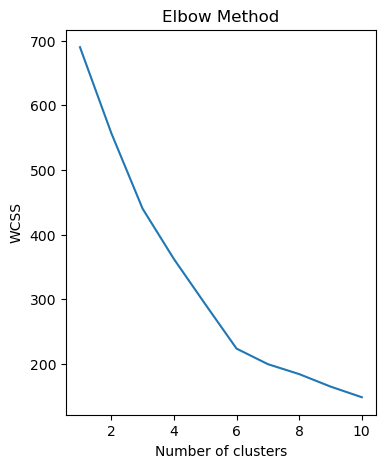

<Figure size 640x480 with 0 Axes>

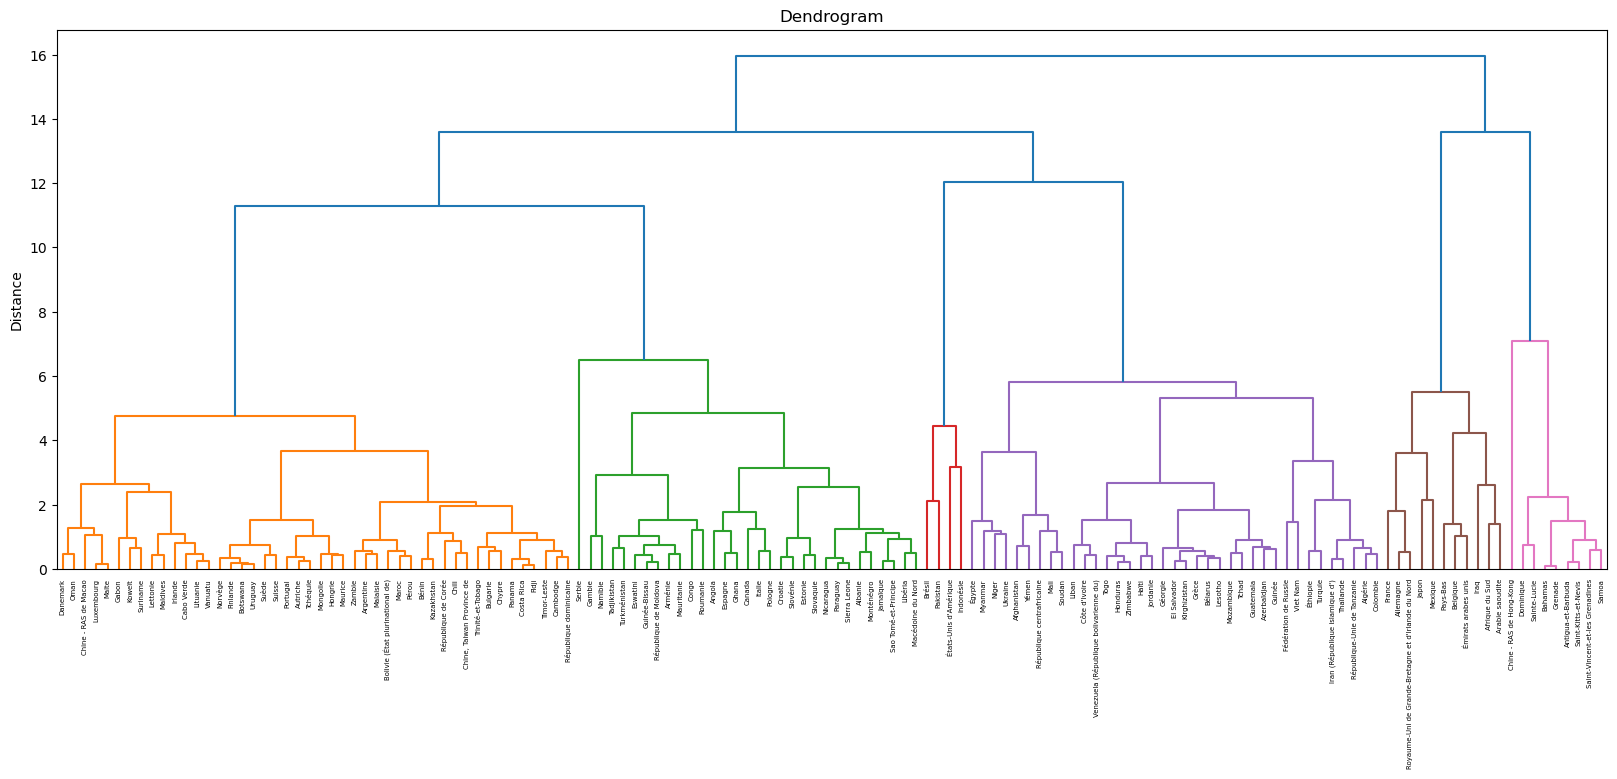

In [10]:
dendro_df = createDendrogram(data_all,Standardscaler,ward)

c:\ProgramData\Anaconda3\envs\Projet_p4\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


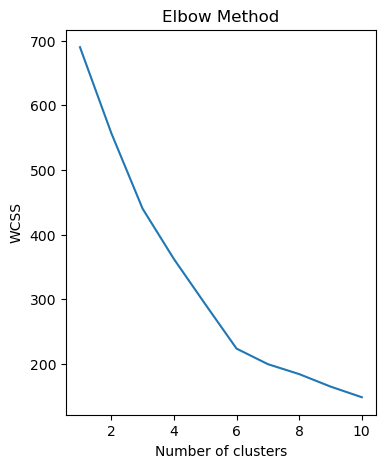

In [11]:
kmean_df = kmeansClustering(data_all, Standardscaler)

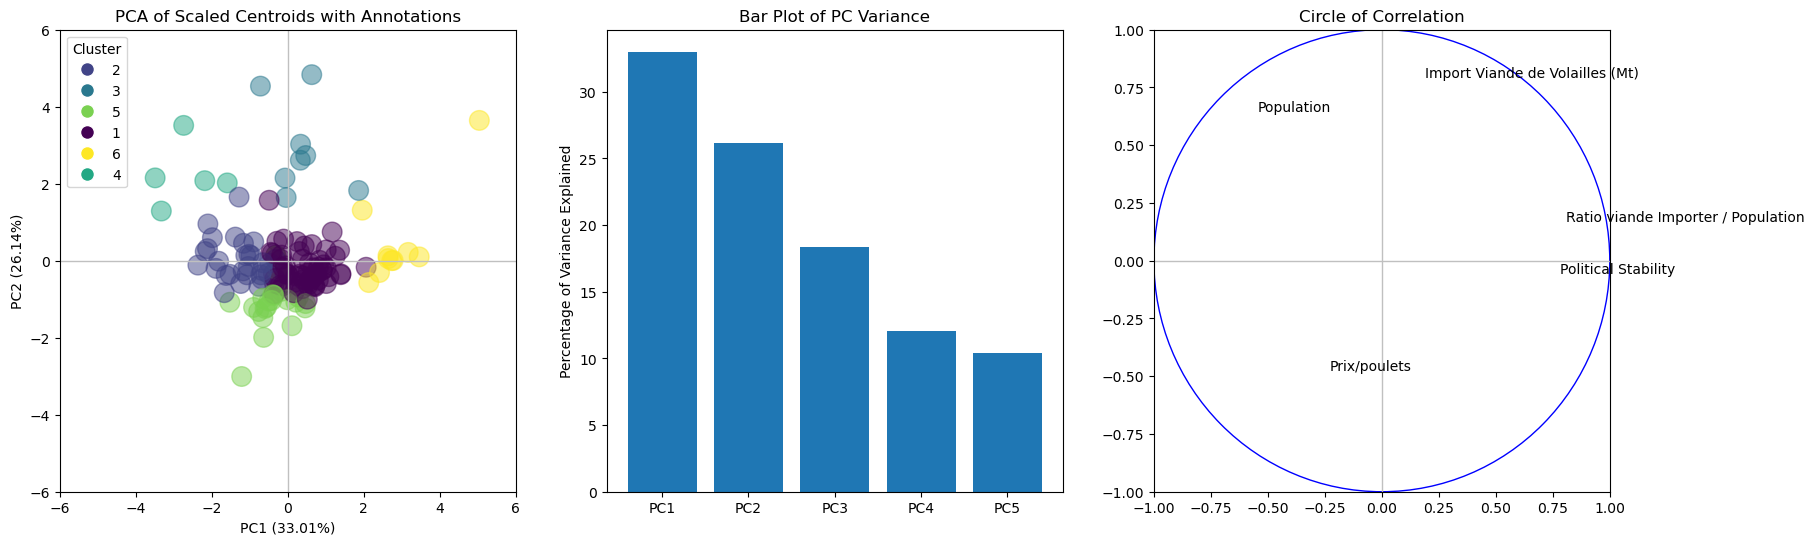

In [12]:
exploreWithPCA(kmean_df)

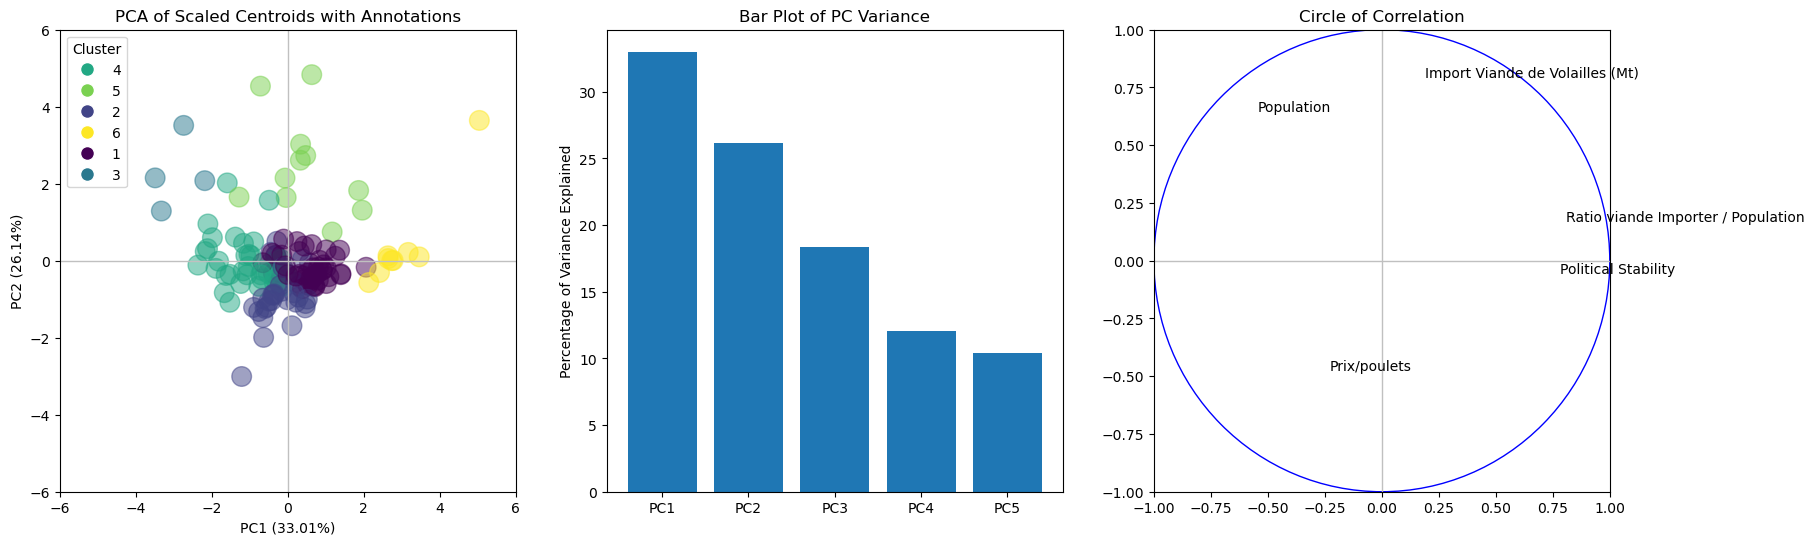

In [13]:
exploreWithPCA(dendro_df)

In [14]:
compare_clustering_results(kmean_df,dendro_df)

Silhouette Score (df1): -0.27531726948561835
Silhouette Score (df2): -0.300616398454979


,Political Stability,Prix/poulets,Import Viande de Volailles (Mt),Population,Ratio viande Importer / Population
Cluster,,,,,
1,0.433594,0.454968,63.890625,1.173012e+07,1.054297e-05
2,-1.283448,0.489069,44.862069,3.666753e+07,1.799281e-06
3,0.196250,0.468969,751.500000,7.170509e+07,1.404827e-05
4,-0.746000,0.682493,71.000000,2.302012e+08,3.918279e-07
5,-0.060909,1.860788,43.772727,8.785336e+06,6.843117e-06
6,0.911000,0.321741,142.200000,1.799122e+06,7.262027e-05


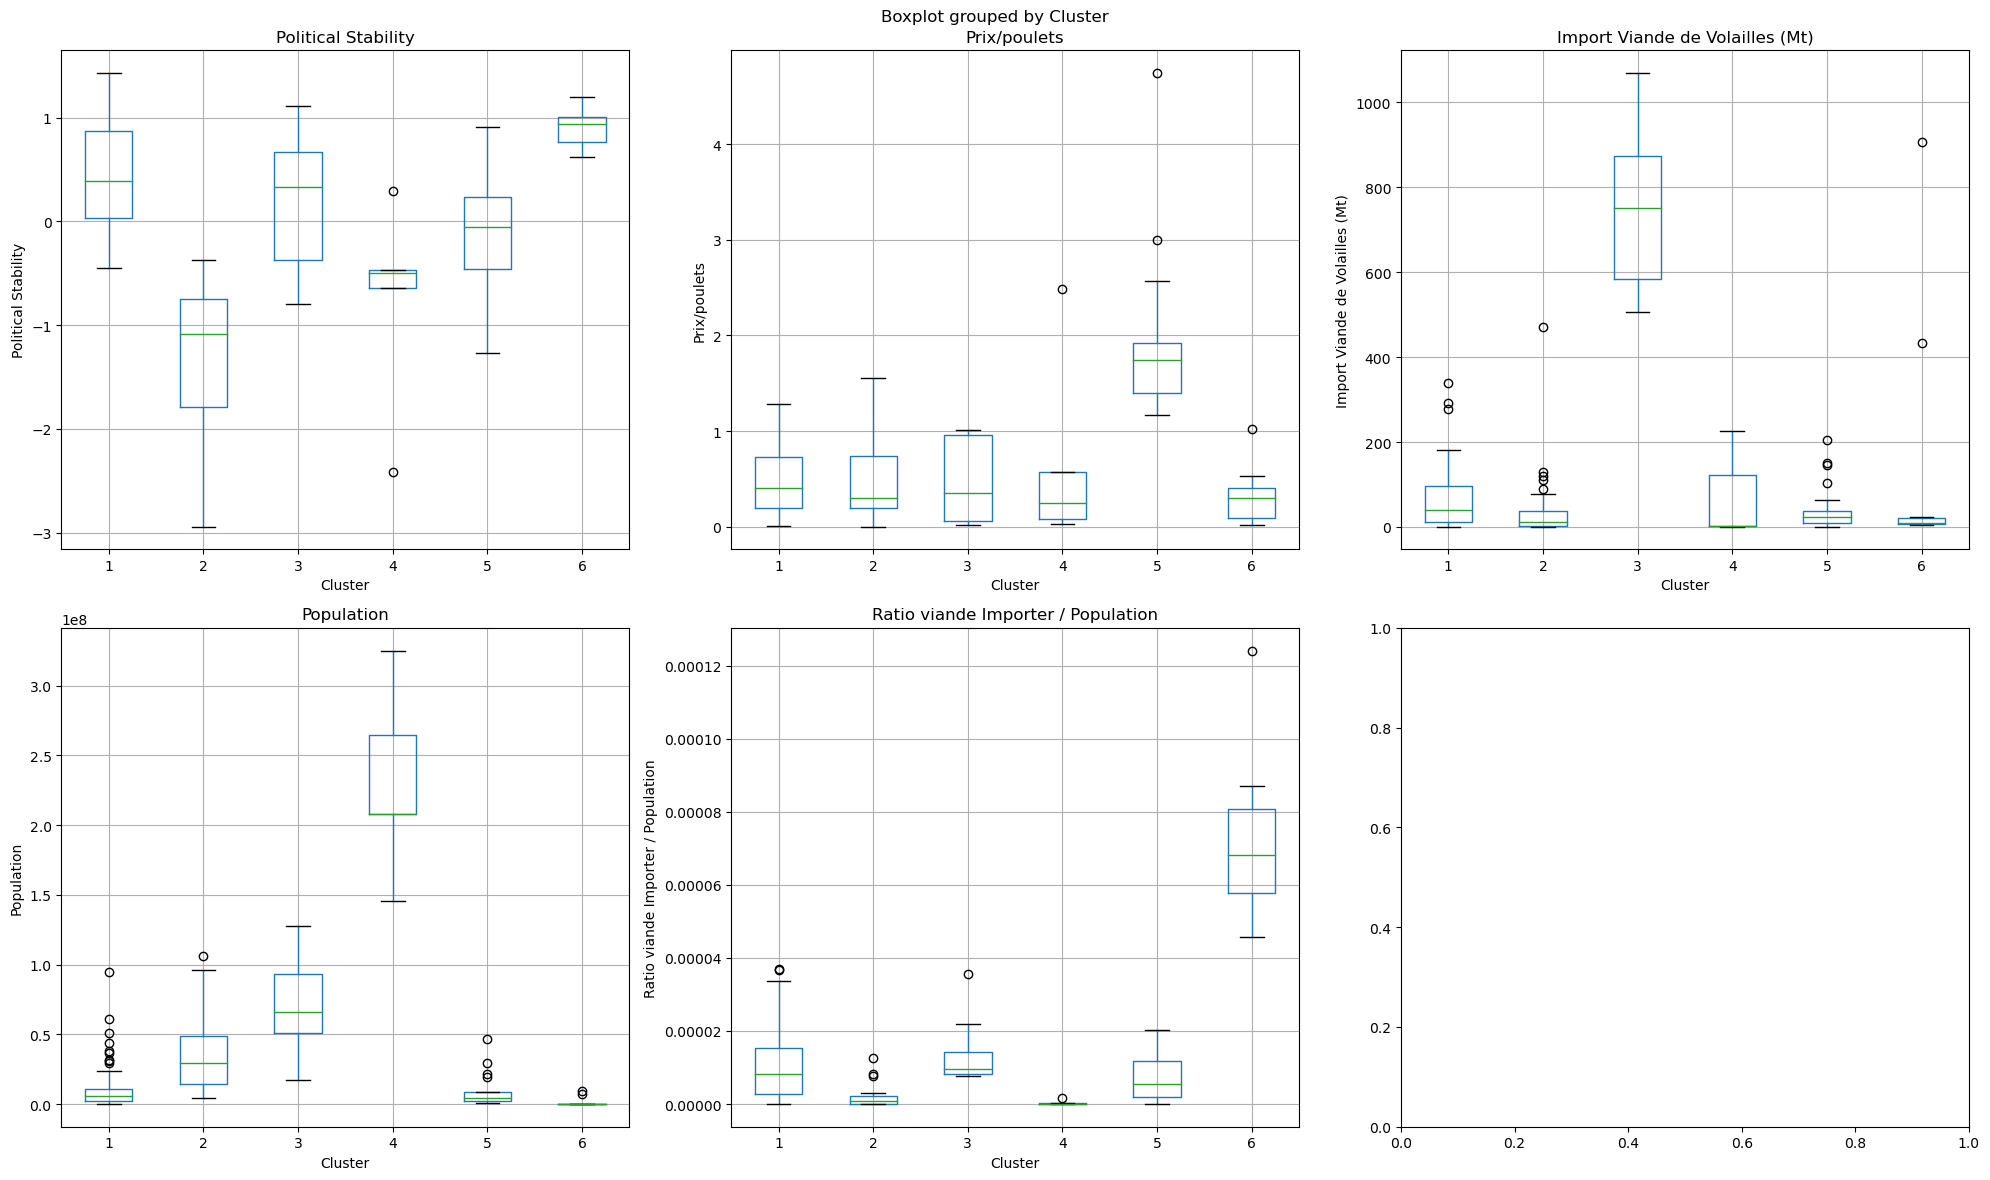

,Political Stability,Prix/poulets,Import Viande de Volailles (Mt),Population,Ratio viande Importer / Population
Cluster,,,,,
1,0.569565,0.326137,52.913043,9.744684e+06,1.134631e-05
2,0.071613,1.566974,55.419355,1.145884e+07,7.353727e-06
3,-0.772500,0.790431,32.250000,2.513689e+08,1.015489e-07
4,-1.026757,0.533888,43.756757,3.514706e+07,2.351926e-06
5,0.028182,0.485799,659.363636,5.746368e+07,1.819456e-05
6,0.943333,0.309118,109.888889,9.448903e+05,7.561803e-05


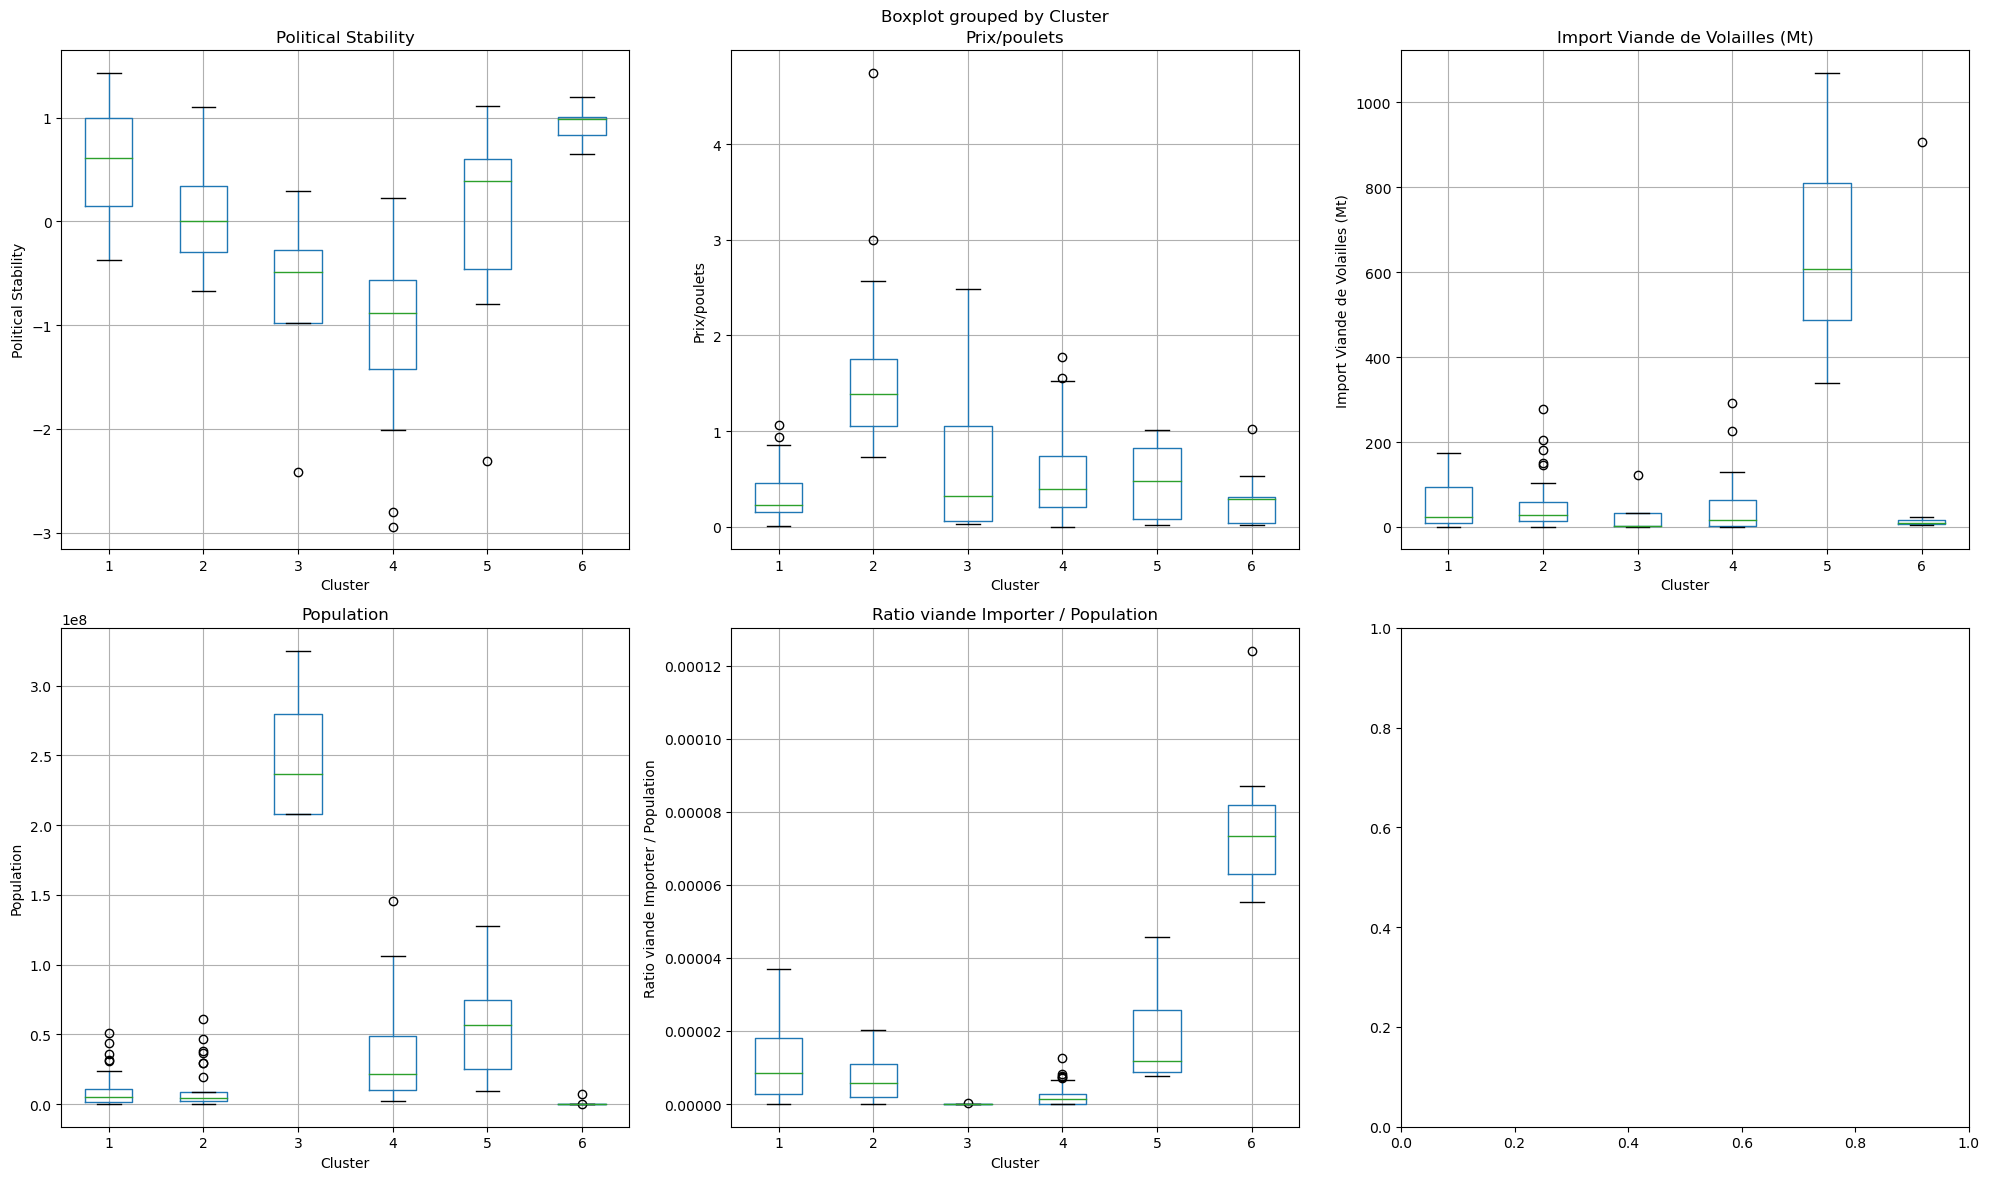

In [15]:
exploreCentroids(kmean_df)
exploreCentroids(dendro_df)

In [16]:
compare_cluster_indices(kmean_df,dendro_df,3,5)

,Political Stability,Prix/poulets,Import Viande de Volailles (Mt),Population,Ratio viande Importer / Population
Cluster,,,,,
3,0.196250,0.468969,751.500000,7.170509e+07,0.000014
5,0.028182,0.485799,659.363636,5.746368e+07,0.000018


,DF1 Indices,DF2 Indices
0,Afrique du Sud,Afrique du Sud
1,Allemagne,Allemagne
2,Arabie saoudite,Arabie saoudite
3,France,Belgique
4,Japon,Émirats arabes unis
5,Mexique,France
6,Pays-Bas,Iraq
7,Royaume-Uni de Grande-Bretagne et d'Irlande du...,Japon
8,NaN,Mexique
9,NaN,Pays-Bas


In [24]:
kmean_df[kmean_df['Cluster'].isin([5])].sort_values('Import Viande de Volailles (Mt)', ascending=False)

,Political Stability,Prix/poulets,Import Viande de Volailles (Mt),Population,Ratio viande Importer / Population,Cluster
Zone,,,,,,
Espagne,0.28,1.335075,205.0,46647428,4.394669e-06,5
Ghana,0.09,1.301200,151.0,29121465,5.185179e-06,5
Roumanie,0.06,2.225178,146.0,19653969,7.428525e-06,5
Congo,-0.53,1.752000,104.0,5110695,2.034948e-05,5
Slovaquie,0.91,1.814956,63.0,5447900,1.156409e-05,5
Albanie,0.38,1.399878,38.0,2884169,1.317537e-05,5
Tadjikistan,-0.67,1.954447,38.0,8880268,4.279150e-06,5
Arménie,-0.62,1.636124,35.0,2944791,1.188539e-05,5
Namibie,0.63,2.564516,29.0,2402633,1.207009e-05,5
